In [ ]:
#Mounts your google drive into this virtual machine

from google.colab import drive, files
import sys
drive.mount('/content/drive')
#Now we need to access the files downloaded, copy the path where you saved the files downloaded from the github repo and paste below

sys.path.append('/content/drive/MyDrive/YOURPATH/SignalValidation/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/YOURPATH/SignalValidation/


/content/drive/MyDrive/CogFlex


In [ ]:
!pip install neurokit2
!pip install mne
!pip install --upgrade pandas


In [ ]:
%matplotlib inline
import signal_formatpeaks
import time
import numpy as np
import pandas as pd
import matplotlib
import neurokit2 as nk
import mne
import matplotlib.pyplot as plt
import os

import random

from sklearn.cross_decomposition import CCA
from scipy import signal

from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq, ifft

import pickle
plt.rcParams['figure.figsize'] = [30, 20]

## **Offline EOG data visualization and processing**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/YOURPATH/SharedPublicly/Data/Blink_EOG_RAW-2021-09-03_12-03-27.txt',header=4 ,sep=r'\s*,\s*',engine='python')
data.columns = ["Sample Index",	"EMG Channel 0",	"EMG Channel 1",	"EMG Channel 2",	"EMG Channel 3",	"EOG Channel 0",	"EOG Channel 1",	"EEG Channel 0",	"EEG Channel 1",	"EEG Channel 2",	"EEG Channel 3",	"EEG Channel 4",	"EEG Channel 5",	"EEG Channel 6",	"EEG Channel 7",	"EEG Channel 8",	"EEG Channel 9",	"PPG Channel 0",	"PPG Channel 1",	"EDA_Channel_0",	"Other",	"Raw PC Timestamp",	"Raw Device Timestamp",	"Other.1",	"Timestamp",	"Marker",	"Timestamp (Formatted)"]
data

In [ ]:
def eog_process_detrend(veog_signal, sampling_rate=1000, **kwargs):
    """Process an EOG signal.

    Convenience function that automatically processes an EOG signal.


    Parameters
    ----------
    veog_signal : Union[list, np.array, pd.Series]
        The raw vertical EOG channel. Note that it must be positively oriented, i.e., blinks must
        appear as upward peaks.
    sampling_rate : int
        The sampling frequency of `eog_signal` (in Hz, i.e., samples/second). Defaults to 1000.
    **kwargs
        Other arguments passed to other functions.

    Returns
    -------
    signals : DataFrame
        A DataFrame of the same length as the `eog_signal` containing the following columns:
        - *"EOG_Raw"*: the raw signal.
        - *"EOG_Clean"*: the cleaned signal.
        - *"EOG_Blinks"*: the blinks marked as "1" in a list of zeros.
        - *"EOG_Rate"*: eye blinks rate interpolated between blinks.

    info : dict
        A dictionary containing the samples at which the eye blinks occur, accessible with the key "EOG_Blinks"
        as well as the signals' sampling rate.

    See Also
    --------
    eog_clean, eog_findpeaks

    Examples
    --------
    >>> import neurokit2 as nk
    >>>
    >>> # Get data
    >>> eog_signal = nk.data('eog_100hz')
    >>>
    >>> signals, info = nk.eog_process(eog_signal, sampling_rate=100)

    References
    ----------
    - Agarwal, M., & Sivakumar, R. (2019, September). Blink: A Fully Automated Unsupervised Algorithm for
    Eye-Blink Detection in EEG Signals. In 2019 57th Annual Allerton Conference on Communication, Control,
    and Computing (Allerton) (pp. 1113-1121). IEEE.

    """
    # Sanitize input
    eog_signal = nk.as_vector(veog_signal)

    # Clean signal
    # eog_cleaned = eog_clean(eog_signal, sampling_rate=sampling_rate, **kwargs)
    eog_cleaned = nk.signal_detrend(eog_signal)
    eog_cleaned = nk.signal_filter(eog_cleaned, lowcut=0.05, highcut=100)
    eog_cleaned = eog_cleaned - np.mean(eog_cleaned)

    eog_signal = eog_signal - np.mean(eog_signal)

    # Find peaks
    peaks = nk.eog_findpeaks(eog_cleaned, sampling_rate=sampling_rate, **kwargs)

    info = {"EOG_Blinks": peaks}
    info['sampling_rate'] = sampling_rate  # Add sampling rate in dict info

    # Mark (potential) blink events
    signal_blinks = signal_formatpeaks._signal_from_indices(peaks, desired_length=len(eog_cleaned))

    # Rate computation
    rate = nk.signal_rate(peaks, sampling_rate=sampling_rate, desired_length=len(eog_cleaned))

    # Prepare output
    signals = pd.DataFrame(
        {"EOG_Raw": eog_signal, "EOG_Clean": eog_cleaned, "EOG_Blinks": signal_blinks, "EOG_Rate": rate}
    )

    return signals, info

In [ ]:
#Collect and process EOG
eog_signal =data["EOG Channel 0"]
eog_signal = nk.as_vector(eog_signal)  # Extract the only column as a vector
signals2, info = eog_process_detrend(eog_signal[1250:], sampling_rate=250) #make sure to split eog_signal correctly

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


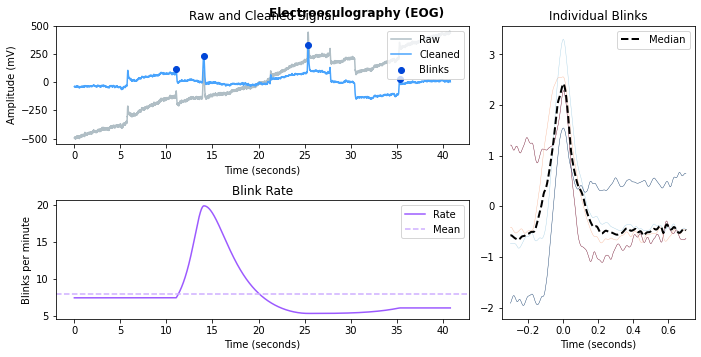

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plot = nk.eog_plot(signals2, info, sampling_rate=250)
path = '/content/drive/MyDrive/YOURPATH/SharedPublicly/Figures'
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'galea_eog.eps'
plot.savefig(path+image_name, format=image_format, dpi=1200)
plt.tight_layout()

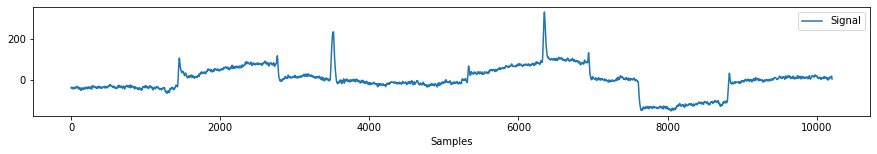

In [ ]:
plt.rcParams['figure.figsize'] = [15, 2]
nk.signal_plot(signals2.EOG_Clean)